# AntClust rule visualization 

This notebook will define functions to generate a simple float dataset and labels for clustering.
It will then test AntClust on these sets.
The process will be visualized by methods defined in view_antclust.py.   
    

# imports

In [1]:
# make AntClus dir known
import sys

sys.path.append("../AntClust")

# generally used
import random as rng
import time
from concurrent.futures import ProcessPoolExecutor

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from distance_classes import similarity_1d
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from rules import labroche_rules
from sklearn.metrics import adjusted_rand_score, rand_score

# data generation methods

In [2]:
def uniform_cluster_data_random(
    num_clusters,
    cluster_width,
    values_per_cluster_min=0,
    values_per_cluster_max=100,
    rng_seed=1,
):
    """
    Makes a series of numbers that can be clustered together.
    Each cluster is getting a pivot element, starting by one and counts to
    num_clusters. From this a random deviation is generated which will be
    the new data point. If the deviation is to larg there will be a string
    of numbers with no space in between and as such no clusters.
    cluster_width: how far can the data point be from its pivot,
    only values <0.25 makes sense.
    """
    # variables
    data = []
    labels = []

    rng.seed(rng_seed)
    rand_min = -cluster_width
    rand_max = cluster_width
    rand_range = rand_max - rand_min

    # make data for each cluster pivot
    for c_pivot in range(1, num_clusters + 1):
        c_data = []
        c_labels = []

        # how many values to generate?
        values_per_cluster = rng.randint(values_per_cluster_min, values_per_cluster_max)
        # generate data points
        for n in range(0, values_per_cluster):
            # calc pivot deviation and add it
            dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # check if exist and if create new
            while dp in c_data:
                dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # add it with the labe to the cluster data
            c_data.append(dp)
            c_labels.append(c_pivot - 1)

        # add the cluster data to overall data
        data = data + c_data
        labels = labels + c_labels

    return data, labels


def uniform_cluster_data(num_clusters, cluster_width, values_per_cluster, rng_seed=1):
    """
    Makes a series of numbers that can be clustered together.
    Each cluster is getting a pivot element, starting by one and counts to
    num_clusters. From this a random deviation is generated which will be
    the new data point. If the deviation is to larg there will be a string
    of numbers with no space in between and as such no clusters.
    cluster_width: how far can the data point be from its pivot,
    only values <0.25 makes sense.
    """
    # variables
    data = []
    labels = []

    rng.seed(rng_seed)
    rand_min = -cluster_width
    rand_max = cluster_width
    rand_range = rand_max - rand_min

    # make data for each cluster pivot
    for c_pivot in range(1, num_clusters + 1):
        c_data = []
        c_labels = []

        # generate data points
        for n in range(0, values_per_cluster):
            # calc pivot deviation and add it
            dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # check if exist and if create new
            while dp in c_data:
                dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # add it with the labe to the cluster data
            c_data.append(dp)
            c_labels.append(c_pivot - 1)

        # add the cluster data to overall data
        data = data + c_data
        labels = labels + c_labels

    return data, labels

# TODO:
# - run with different seeds and take the mean error
def run_benchmark():
    # generate two for loops that generate the data and then run antclust
    # and save the error to a 2d list of lists

    return []

# test functions


In [3]:
# -----------------------------------
# single process tests
# -----------------------------------

def run_cluster_test_static(
    clusters_min,
    clusters_max,
    values_min,
    values_max,
    cluster_width,
    specific_rule,
    ant_clust_params={"alpha": 150, "betta": 0.5, "shrink": 0.2, "removal": 0.3},
    dropout=False,
    dynamic_acceptance=False,
    seed=3
):
    # variables
    fitness_ari = []
    fitness_ri = []

    # run all tests
    for num_clusters in range(clusters_min, clusters_max + 1):
        c_fitness_ari = []
        c_fitness_ri = []
        #print(f"testing values for {num_clusters} clusters")
        for values_per_cluster in range(values_min, values_max + 1):
            # ------------------
            # data
            # ------------------
            data, labels = uniform_cluster_data(
                num_clusters, cluster_width, values_per_cluster, seed
            )
            data = np.array(data)
            labels = np.array(labels)

            # ------------------
            # run clustering
            # ------------------
            # similarity function
            f_sim = [similarity_1d(data.min(), data.max())]

            # AntClust
            ant_clust = AntClust(
                f_sim,
                specific_rule,
                alpha_ant_meeting_iterations=ant_clust_params["alpha"],
                betta_template_init_meetings=ant_clust_params["betta"],
                nest_shrink_prop=ant_clust_params["shrink"],
                nest_removal_prop=ant_clust_params["removal"],
                print_status=False,
                dropout=dropout,
                dynamic_template_adaptation=dynamic_acceptance
            )

            # find clusters
            ant_clust.fit(data)

            # get the clustering result
            clusters_found = ant_clust.get_clusters()

            # ------------------
            # calc error
            # ------------------
            # use ari as score
            ari = adjusted_rand_score(labels, clusters_found)
            c_fitness_ari.append(ari)

            # use ri as score
            ri = rand_score(labels, clusters_found)
            c_fitness_ri.append(ri)

        # append fitness for that cluster ammount
        fitness_ari.append(c_fitness_ari)
        fitness_ri.append(c_fitness_ri)

    # finally
    return fitness_ari, fitness_ri

# Visualization 

In [4]:
import AntClust
from importlib import reload
import view_antclust
reload(AntClust)
reload(view_antclust)

data, labels = uniform_cluster_data(3, 0.2, 18, 9)
data = np.array(data)
labels = np.array(labels)

# ------------------
# run clustering
# ------------------
# similarity function
f_sim = [similarity_1d(data.min(), data.max())]
ant_clust_params={"alpha": 150, "betta": 0.5, "shrink": 0.2, "removal": 0.3}
# AntClust
ant_clust = AntClust.AntClust(
    f_sim,
    labroche_rules(),
    alpha_ant_meeting_iterations=ant_clust_params["alpha"],
    betta_template_init_meetings=ant_clust_params["betta"],
    nest_shrink_prop=ant_clust_params["shrink"],
    nest_removal_prop=ant_clust_params["removal"],
    print_status=False,
    visualization=True
)

print(f"Data length: {len(data)}")
print(f"Meeting length: {int(len(data)*ant_clust_params['alpha']*0.5)}")
ant_clust

# # find clusters
cluster_evolution, rule_applied = ant_clust.fit(data)
ari_evolution = [adjusted_rand_score(labels, cluster) for cluster in cluster_evolution]


Data length: 54
Meeting length: 4050


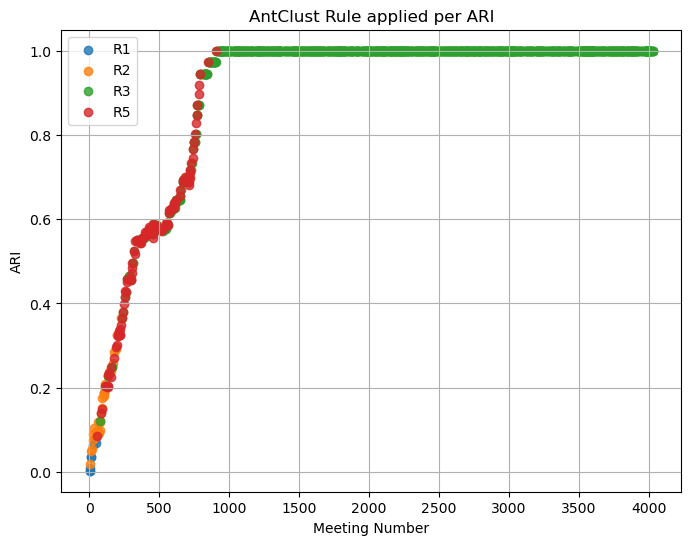

In [9]:

reload(view_antclust)
view_antclust.visualize_meetings(ari_evolution, rule_applied)

<Figure size 1600x800 with 0 Axes>

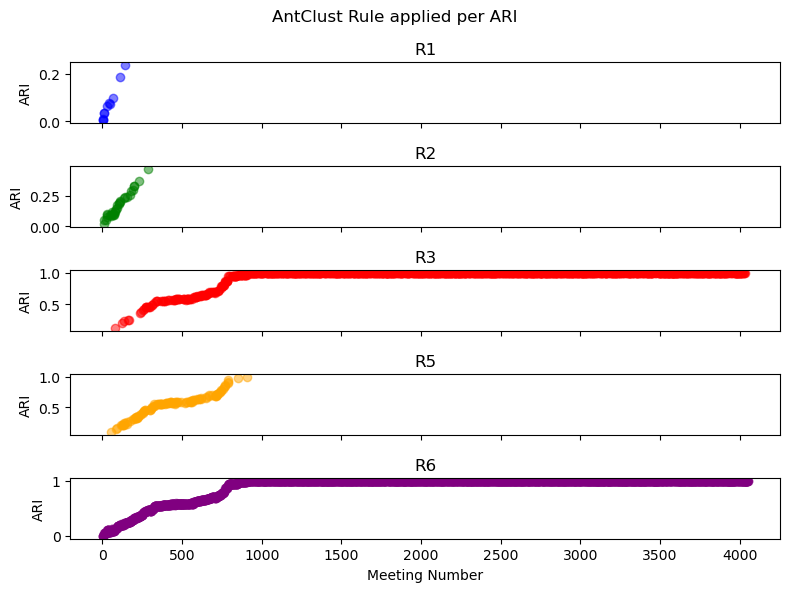

In [10]:
view_antclust.visualize_meetings_subplots(ari_evolution, rule_applied)